# Using CovIndia API 

In this notebook, we will show
- How to use the CovIndia API, to generate CSVs (which can be opened in Microsoft Excel)
- Do some basic analysis like day-wise state and district numbers.
- A small example of plotting the infected numbers for a given state, and doing some curve fitting to smoothen the graph. 
- An example of the kind of analysis possible with our data.

We hope the data science and research community will take this analysis further.

#### Using CovIndia API to generate CSV containing the entire dataset

In [2]:
import requests        # Needs to be installed (pip install requests)
import json
import pandas as pd    # Needs to be installed (pip install pandas)

In [3]:
url = 'https://v1.api.covindia.com/covindia-raw-data'
raw_data = requests.get(url=url).json()
# Next line is just to change the type of keys from string to int
# This is required for making the dataframe automatically
raw_data = {int(old_key): val for old_key, val in raw_data.items()}
#print(raw_data)

In [4]:
raw_data_df = pd.DataFrame.from_dict(raw_data, orient='index')
raw_data_df  = raw_data_df [['date','time','district','state','infected','death','source']]
raw_data_df["date"] = pd.to_datetime(raw_data_df["date"],dayfirst=True)
raw_data_df.to_csv('raw_data.csv', index = False)
raw_data_df.head()

,date,time,district,state,infected,death,source
0,2020-04-07,22:17,Rangareddi,Telangana,5,0,https://pbs.twimg.com/media/EVAyEo6UYAAn0Iz.jpg
1,2020-04-07,22:17,Khammam,Telangana,3,0,https://pbs.twimg.com/media/EVAyEo6UYAAn0Iz.jpg
2,2020-04-07,22:17,Nalgonda,Telangana,21,0,https://pbs.twimg.com/media/EVAyEo6UYAAn0Iz.jpg
3,2020-04-07,22:17,Nizamabad,Telangana,7,0,https://pbs.twimg.com/media/EVAyEo6UYAAn0Iz.jpg
4,2020-04-07,22:17,Adilabad,Telangana,11,0,https://pbs.twimg.com/media/EVAyEo6UYAAn0Iz.jpg


#### Performing some basic aggregations

In [5]:
# Finding the total infected and death
print('Total Infected : ' + str(raw_data_df['infected'].sum()))
print('Total Death : ' + str(raw_data_df['death'].sum()))

Total Infected : 5152
Total Death : 168


In [6]:
# Aggregating the data daywise and districtwise
dist_day_df = raw_data_df.groupby(['date', 'district'], as_index=False)['infected','death'].sum()
dist_day_df = dist_day_df.sort_values('date', ascending = True)
dist_day_df.head()

,date,district,infected,death
0,2020-02-03,Kannur,1,0
1,2020-03-02,Delhi,7,0
2,2020-03-02,Hyderabad,5,0
3,2020-03-04,Gurgaon,14,0
4,2020-03-04,Jaipur,1,0


In [7]:
# Aggregating the data daywise and statewise
state_day_df = raw_data_df.groupby(['date', 'state'], as_index=False)['infected','death'].sum()
state_day_df.head()

,date,state,infected,death
0,2020-02-03,Kerala,1,0
1,2020-03-02,Delhi,7,0
2,2020-03-02,Telangana,5,0
3,2020-03-04,Haryana,14,0
4,2020-03-04,Rajasthan,1,0


#### Plot the data for a given state or district

Text(0.5, 1.0, 'Infected numbers for Maharashtra')

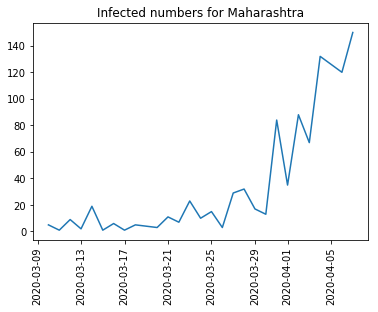

In [9]:
# Plotting infected numbers for a particular state

%matplotlib inline
from matplotlib import pyplot as plt
maharashtra_df = state_day_df[state_day_df['state']=='Maharashtra']
#maharashtra_df  = maharashtra_df.sort_values('date', ascending=True)
plt.plot(maharashtra_df['date'], maharashtra_df['infected'])
plt.xticks(rotation='vertical')
plt.title('Infected numbers for Maharashtra')

As we can see, the graph is not very smooth. This is simply because of the testing as more tests are happening every alternate day. This has been observed at the India level. We can smoothen out these fluctuations to get a slightly better picture in terms of data analysis.

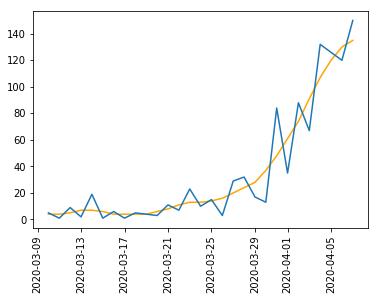

In [18]:
from scipy.ndimage.filters import gaussian_filter1d
import numpy as np

ysmoothed = gaussian_filter1d(np.array(maharashtra_df['infected']), sigma=1.5)
plt.plot(np.array(maharashtra_df['date']), ysmoothed, color='orange')
plt.plot(maharashtra_df['date'], maharashtra_df['infected'])
plt.xticks(rotation='vertical')
plt.show()

#### Further Analysis

The most promising analysis would be based on weather as this data has district level accuracy. We did some preliminary analysis and found the following interesting, but as yet unconclusive results:

<img src="delhi_trend.JPG">

Here we see a slight negative trend in the percentage increase in new cases as temperature increases. To be sure, each point here corresponds to a particular day in delhi, and the temperature is taken to be the temperature 5 days earlier as Covid-19 requires atleast that much time to be detected. We know that actually it could be anywhere between 5 - 14 days, but taking an average over such a large period will hide any effects due to temperature, as tll the averages will be virtually the same.

This reconfirms the intuition that heat is bad for the spread of Virus and gives some hope in the case of countries like India. However, evn then, the effect of temperature is not as big as previously expected. If one naively extrapolates this trend, the percentage increase goes to zero only at 65 degrees centigrade. We will die of heat before that! 

You might say, we are cherry-picking and giving people false hope. While we agree that this is barely enough data to throw caution to the wind, interestingly even Mumbai data shows a similar picture.

<img src="mumbai_trend.JPG">

One could look at similar trends when it comes to humidity or Atmospheric pressure. Population density could also play a key role in determining the speed of the spread. An analysis using the world cities all on one graph might give us enough data points to have a mor conclusive  A lot of deeper analysis can be done based on our district-wise data. 

We hope that this notebook will serve you as a base for further exploration. If you do find interesting results, *please share them with us*. Also, we would love if you cite our work in case you publish research articles or reports.